Work book Notes:

In this notebook we will first use stacking models on preprocessed data with no polynomial form. Then will build stacking models on polynomial data forms.



In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [7]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [9]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [10]:
replace_age_fraction(df_train)

0


In [11]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [12]:
import h2o

In [15]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,09 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_hamza_0oce4c
H2O cluster total nodes:,1
H2O cluster free memory:,5.317 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [16]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


## Super Learning:

As Super learning is process learning of two layer of models, i.e. we in first layer(base model) we will use Random Forest, Gradient Boosting Machine, Naive Bayse and Deep Learning as Meta Learner

In [17]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [18]:
nfolds =5
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
# Train and cross-validate a NB
my_nb =H2ONaiveBayesEstimator(seed =1,
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [ ]:
# Train and cross-validate a DL
my_dl = H2ODeepLearningEstimator(seed =1,  
                              hidden=[200,200,200,100],
                              epochs =1000,
                              l2= 1e-45,
                              l1=1e-2,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |████

In [21]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm.model_id, my_rf.model_id])
ensemble.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.997807017544
valid accuracy: 0.898047004303


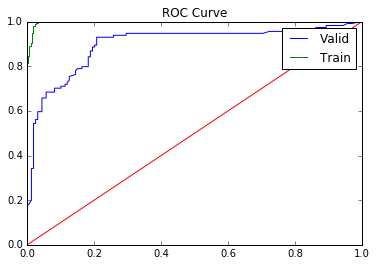

In [22]:
def model_performance(model =  ensemble):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance(ensemble)

In [23]:
# Train a stacked ensemble using the GBM and GLM above
ensemble1_0 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_0",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_nb.model_id])
ensemble1_0.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.996541835358
valid accuracy: 0.895067858325


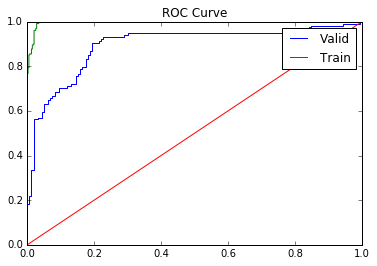

In [24]:
model_performance(ensemble1_0)

In [4]:
# h2o.shutdown()

[WARNING] in <ipython-input-4-bd1e984f485f> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_abc5 closed.
